# **Installing libraries**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

----

# **First Part**

## **Loading the VGG model**

In [ ]:
# This is the pretrained VGG model for feature extraction
model = VGG16(weights='imagenet', include_top=False)
# This shows the layers and parameters of the pretrained model
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## **Function to load and preprocess images**

In [ ]:
def load_preprocess_image(ruta):
    """
    Loads an image from a specified path and preprocesses it for VGG16.

    Steps:
        1. Reads the image from disk.
        2. Checks for loading errors.
        3. Converts the image from BGR to RGB.
        4. Resizes the image to 224x224 pixels (VGG16 input size).
        5. Converts the image to a numpy array of type float32.
        6. Adds a batch dimension.
        7. Applies VGG16 preprocessing (mean subtraction, scaling, etc.).

    Args:
        ruta (str): Path to the input image file.

    Returns:
        numpy.ndarray: Preprocessed image array of shape (1, 224, 224, 3) ready
                       to be fed into VGG16 or similar convolutional networks.

    Raises:
        ValueError: If the image cannot be loaded from the specified path.
    """
    img = cv2.imread(ruta)

    # Basic error check
    if img is None:
      raise ValueError("Could not load image from the specified path.")

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to the VGG required size
    img_resized = cv2.resize(img_rgb, (224, 224))

    # Convert to a numpy array
    x = np.array(img_resized, dtype=np.float32)
    # Add batch dimension
    x = np.expand_dims(x, axis=0)

    # Prepare it for the network
    x = preprocess_input(x)

    return x

## **Function to extract features from an image**

In [ ]:
def extract_features(img_prep, model):
  """
    Extracts features from a preprocessed image using a convolutional model.

    Args:
        img_prep (numpy.ndarray): Preprocessed image of shape (1, H, W, C)
        model (keras.Model): Convolutional part of VGG16

    Returns:
        numpy.ndarray: Flattened feature vector
  """
  features = model.predict(img_prep)
  features_vector = features.flatten()
  return features_vector

## **Function to normalize feature vectors**

In [ ]:
def normalize_vector(feature_vector):
    """
    Normalizes a feature vector to have unit length.

    This ensures that all feature vectors are on the same scale,
    preventing some vectors from dominating due to their magnitude.

    Args:
        feature_vector (numpy.ndarray): Input 1D feature vector.

    Returns:
        numpy.ndarray: Normalized feature vector with unit length.
                       If the input vector has zero norm (all zeros), it
                       is returned unchanged to avoid division by zero.
    """
    # Vector length
    norm = np.linalg.norm(feature_vector)
    # If the norm is 0 (all elements are 0), return the vector unchanged
    if norm == 0:
        return feature_vector

    # Divide by the norm to normalize
    return feature_vector / norm

## **I do all the process using the function I've just created**

In [ ]:
# Load and preprocess the image
img_array = load_preprocess_image('calzoncillo.png')

# Extract the image features with the VGG16 model
features = extract_features(img_array, model)

# Normalize the vector of features
normalized_features = normalize_vector(features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


----
# **Second Part**

## **Download a dataset of clothes.**

In [ ]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git


fatal: destination path 'clothing-dataset-small' already exists and is not an empty directory.


In [ ]:
# Data structure to store the repository data
data = []

# I iterate over the train, validation and test data
for split in ['train', 'validation', 'test']:
    base_path = f'clothing-dataset-small/{split}'
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        for image_name in os.listdir(label_path):
            full_path = os.path.join(label_path, image_name)
            data.append({
                'name': image_name,
                'label': label,
                'path': full_path
            })

# I create the df and I save it as a csv
df = pd.DataFrame(data)
df.to_csv('catalogo.csv', index=False)

### **Function to compute feature vectors of the images listed in a CSV for similarity calculation**

In [ ]:
def process_csv(csv_path, model, n_imagenes=200):
  """
  Processes a CSV of images, extracting and normalizing feature vectors for each image.

  This function:
      1. Loads the CSV containing image paths and labels.
      2. Optionally samples a subset of images for faster processing.
      3. Iterates over each image, applying preprocessing, feature extraction,
           and normalization.
      4. Returns a DataFrame with image metadata and a NumPy array of feature vectors.

  Args:
      csv_path (str): Path to the CSV file containing image information.
      model (keras.Model): Convolutional model (e.g., VGG16 without the dense layers)
                            used to extract features.
      n_images (int, optional): Maximum number of images to process. Defaults to 200.

  Returns:
      tuple:
          - pandas.DataFrame: DataFrame with columns ['name', 'label', 'path'].
          - numpy.ndarray: Array of normalized feature vectors for each processed image.
  """
  df = pd.read_csv(csv_path)
  # I use 200 random images as sample for faster processing (full dataset can be used for better accuracy)
  if len(df) > n_imagenes:
        df = df.sample(n=n_imagenes, random_state=42)

  names = []
  labels = []
  paths = []
  vectors = []

  # Iterate over each row in the CSV
  for _, row in df.iterrows():
    path_img = row['path']
    try:
      # Apply previously defined functions
      img_prep = load_preprocess_image(path_img)
      features = extract_features(img_prep, model)
      features_normal = normalize_vector(features)

      names.append(row['name'])
      labels.append(row['label'])
      paths.append(path_img)
      vectors.append(features_normal)
    except Exception as e:
      print(f"Error while processing the image {path_img}: {e}")

  vectors = np.array(vectors)
  # Creo un dataframe con los datos del catalogo procesados
  df_ropa = pd.DataFrame({
      'name': names,
      'label': labels,
      'path': paths,
  })

  return df_ropa, vectors

In [ ]:
df_catalog, vectors_catalog = process_csv('catalogo.csv', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

### **Function to recommend similar products using cosine similarity**

In [ ]:
def recommend_products(img_path, model, catalog_vectors, catalog_meta, top_k=5):
    """
    Recommends similar products based on a query image using cosine similarity.

    This function:
        1. Preprocesses the query image.
        2. Extracts and normalizes its feature vector using a convolutional model.
        3. Computes cosine similarity between the query and all catalog feature vectors.
        4. Returns the top_k most similar items with their similarity scores.

    Args:
        img_path (str): Path to the query image.
        model (keras.Model): Convolutional model used to extract features (e.g., VGG16 without dense layers).
        catalog_vectors (numpy.ndarray): Array of normalized feature vectors for all catalog images.
        catalog_meta (pandas.DataFrame): DataFrame containing catalog metadata (e.g., 'nombre', 'etiqueta', 'ruta').
        top_k (int, optional): Number of top similar items to return. Defaults to 5.

    Returns:
        pandas.DataFrame: DataFrame containing metadata of the top_k recommended items,
                          with an added column 'similitud' indicating similarity scores.
    """
    # Preprocess the input image to look for similarities
    img_prep = cargar_preprocesar_imagen(img_path)

    # Extract and normalize features
    query_features = extraer_features(img_prep, model)
    query_features = normalizar_vector(query_features).reshape(1, -1)

    # Compute cosine similarity with all catalog images
    sim_scores = cosine_similarity(query_features, catalog_vectors)[0]

    # Get the indexs of the top_k most similar images
    top_indexs = np.argsort(sim_scores)[::-1][:top_k]

    # Create a DataFrame with the recommended items
    recomendaciones = catalog_meta.iloc[top_indexs].copy()
    recomendaciones['similitud'] = sim_scores[top_indexs]

    return recomendaciones


### **Function to show the images of the similar objects**

In [ ]:
def show_recommendations(df_resultado):
    """
    Displays recommended images with their labels and similarity scores.

    This function takes a DataFrame containing recommended items and visualizes
    each image side by side using Matplotlib. Each image is shown in RGB format
    with a title indicating its label and similarity score.

    Args:
        df_resultado (pandas.DataFrame): DataFrame containing recommended items,
                                         must include the following columns:
                                         - 'ruta': path to the image file
                                         - 'etiqueta': class/label of the image
                                         - 'similitud': similarity score

    Returns:
        None: The function displays the images and does not return any value.
    """
    plt.figure(figsize=(12, 6))
    for i, row in enumerate(df_resultado.itertuples(), start=1):
        img = cv2.imread(row.ruta)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(df_resultado), i)
        plt.imshow(img)
        plt.title(f"{row.etiqueta}\nSim: {row.similitud:.2f}")
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


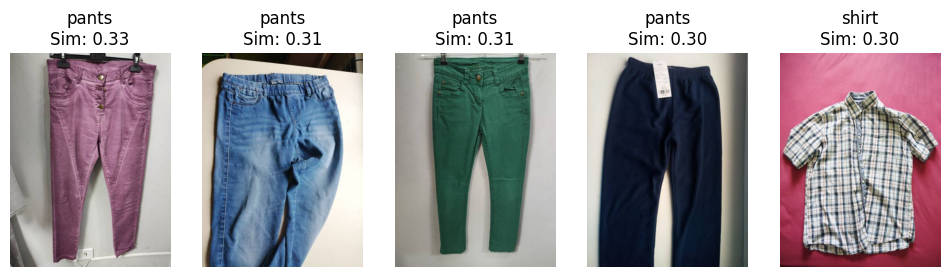

In [ ]:
result = recommend_products('calzoncillo.png', model, vectors_catalog, df_catalog, top_k=5)
# Show results
show_recommendations(result)


**The result shows pants because the dataset does not contain underwear, and pants are the most similar clothing item. I also see a shirt with the same pattern as the underwear image I used. This indicates that the network is correctly capturing the patterns.**

## Now I'm gonna use a different image to see if it really works.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


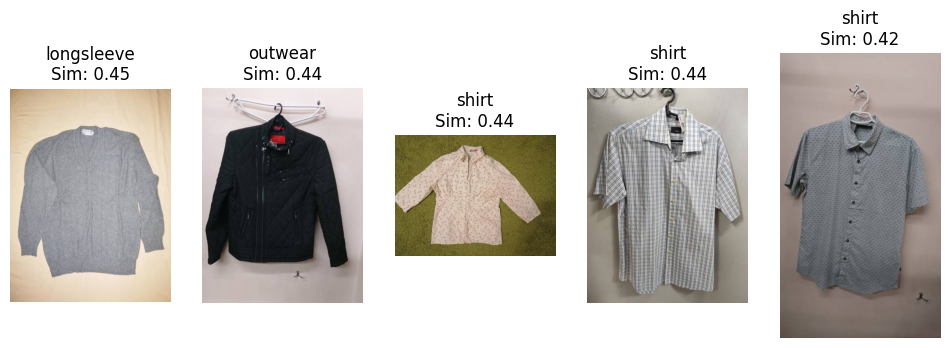

In [ ]:
result = recommend_products('camisa.jpg', model, vectores_catalogo, df_catalogo, top_k=5)
# Show results
show_recommendations(result)

**I observe that using a shirt as a query returns shirts and other similar clothing items, which suggests that the network is working correctly.**